In [51]:
import gym
import tensorflow as tf
import numpy as np

In [52]:
env = gym.make('CartPole-v0')

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

In [97]:
class Data:
    Q = np.array([])
    num_discretized = 0
    def __init__(self, num_discretized, observation_space, action_space):
        l = [num_discretized] * len(observation_space.low)
        l.append(action_space.n)
        self.Q = np.zeros(tuple(l))
        self.num_discretized = num_discretized
        self.high = observation_space.high
        self.low = observation_space.low
        self.high[self.high > 1e30] = 1e30
        self.low[self.low < -1e30] = -1e30
        
    def get_Q_value(self, observation):
        idxs = self.get_indices(observation)
        return self.Q[tuple(idxs)]
    
    def __bins(self, clip_min, clip_max, num):
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]
    
    def get_indices(self, observation):
        # idxs = np.floor((observation - self.low) / ((self.high - self.low)/self.num_discretized)).astype(np.int16)
        idxs = np.array([np.digitize(observation[0], bins=self.__bins(-2.4, 2.4, self.num_discretized)),
                        np.digitize(observation[1], bins=self.__bins(-3.0, 3.0, self.num_discretized)),
                        np.digitize(observation[2], bins=self.__bins(-0.5, 0.5, self.num_discretized)),
                        np.digitize(observation[3], bins=self.__bins(-2.0, 2.0, self.num_discretized))])
        return idxs
        
        
    # [3]Qテーブルを更新する関数 -------------------------------------
    def update_Data(self, observation, action, reward, next_observation, alpha, gamma):
        next_Max_Q=np.max(self.get_Q_value(next_observation))
        idxs = self.get_indices(observation)
        self.Q[tuple(idxs)][action] = (1 - alpha) * self.Q[tuple(idxs)][action]
        self.Q[tuple(idxs)][action] += alpha * (reward + gamma * next_Max_Q)

In [131]:
train_episodes = 3000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 1.01                   # future reward discount

# Exploration parameters
explore_start = 0.5            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Q-Table parameters
num_discretized = 6

# QLearning parameters
alpha = 0.2

In [132]:
QTable = Data(num_discretized, env.observation_space, env.action_space)

In [133]:
# Now train with experiences
#saver = tf.train.Saver()
rewards_list = []
step = 0
state = env.reset()
for ep in range(1, train_episodes):
    total_reward = 0
    t = 0
    while t < max_steps:
        step += 1

        # Uncomment this next line to watch the training
        # env.render() 

        # Explore or Exploit
        explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
        if explore_p > np.random.rand():
            # Make a random action
            action = env.action_space.sample()
        else:
            action = np.argmax(QTable.get_Q_value(state))

        # Take action, get new state and reward
        next_state, reward, done, _ = env.step(action)

        total_reward += reward
        
        # Train Q-Table
        if done:
            next_Max_Q=0
        else:
            next_Max_Q=np.max(QTable.get_Q_value(next_state))
            
        if done:
            if t < 195:
                #reward = -200  #こけたら罰則
                reward = 1
            else:
                reward = 1  #立ったまま終了時は罰則はなし
        else:
            reward = 1  #各ステップで立ってたら報酬追加

        # QTable.update_Data(state, action, reward, next_state, alpha, gamma)
        idxs = QTable.get_indices(state)
        QTable.Q[tuple(idxs)][action] = (1 - alpha) * QTable.Q[tuple(idxs)][action]
        QTable.Q[tuple(idxs)][action] += alpha * (reward + gamma * next_Max_Q)

        if done:
            # the episode ends so no next state
            # next_state = np.zeros(state.shape)
            t = max_steps

            print('Episode: {}'.format(ep),
                  'Total reward: {}'.format(total_reward),
                  #'Training loss: {:.4f}'.format(loss),
                  'Explore P: {:.4f}'.format(explore_p))
            rewards_list.append((ep, total_reward))

            # Start new episode
            env.reset()
            # Take one random step to get the pole and cart moving
            state, reward, done, _ = env.step(env.action_space.sample())

        else:
            state = next_state
            t += 1

Episode: 1 Total reward: 16.0 Explore P: 0.4992
Episode: 2 Total reward: 15.0 Explore P: 0.4985
Episode: 3 Total reward: 40.0 Explore P: 0.4965
Episode: 4 Total reward: 11.0 Explore P: 0.4960
Episode: 5 Total reward: 11.0 Explore P: 0.4955
Episode: 6 Total reward: 8.0 Explore P: 0.4951
Episode: 7 Total reward: 15.0 Explore P: 0.4943
Episode: 8 Total reward: 83.0 Explore P: 0.4903
Episode: 9 Total reward: 12.0 Explore P: 0.4898
Episode: 10 Total reward: 42.0 Explore P: 0.4878
Episode: 11 Total reward: 14.0 Explore P: 0.4871
Episode: 12 Total reward: 19.0 Explore P: 0.4862
Episode: 13 Total reward: 17.0 Explore P: 0.4854
Episode: 14 Total reward: 12.0 Explore P: 0.4848
Episode: 15 Total reward: 16.0 Explore P: 0.4840
Episode: 16 Total reward: 16.0 Explore P: 0.4833
Episode: 17 Total reward: 46.0 Explore P: 0.4811
Episode: 18 Total reward: 15.0 Explore P: 0.4804
Episode: 19 Total reward: 22.0 Explore P: 0.4794
Episode: 20 Total reward: 58.0 Explore P: 0.4767
Episode: 21 Total reward: 10.0

Episode: 172 Total reward: 52.0 Explore P: 0.3444
Episode: 173 Total reward: 22.0 Explore P: 0.3437
Episode: 174 Total reward: 20.0 Explore P: 0.3430
Episode: 175 Total reward: 61.0 Explore P: 0.3410
Episode: 176 Total reward: 11.0 Explore P: 0.3406
Episode: 177 Total reward: 24.0 Explore P: 0.3398
Episode: 178 Total reward: 37.0 Explore P: 0.3386
Episode: 179 Total reward: 19.0 Explore P: 0.3380
Episode: 180 Total reward: 27.0 Explore P: 0.3371
Episode: 181 Total reward: 20.0 Explore P: 0.3364
Episode: 182 Total reward: 25.0 Explore P: 0.3356
Episode: 183 Total reward: 12.0 Explore P: 0.3352
Episode: 184 Total reward: 13.0 Explore P: 0.3348
Episode: 185 Total reward: 11.0 Explore P: 0.3344
Episode: 186 Total reward: 15.0 Explore P: 0.3340
Episode: 187 Total reward: 61.0 Explore P: 0.3320
Episode: 188 Total reward: 8.0 Explore P: 0.3317
Episode: 189 Total reward: 39.0 Explore P: 0.3305
Episode: 190 Total reward: 10.0 Explore P: 0.3302
Episode: 191 Total reward: 10.0 Explore P: 0.3298
E

Episode: 337 Total reward: 85.0 Explore P: 0.1792
Episode: 338 Total reward: 68.0 Explore P: 0.1781
Episode: 339 Total reward: 14.0 Explore P: 0.1779
Episode: 340 Total reward: 99.0 Explore P: 0.1762
Episode: 341 Total reward: 77.0 Explore P: 0.1749
Episode: 342 Total reward: 106.0 Explore P: 0.1732
Episode: 343 Total reward: 53.0 Explore P: 0.1723
Episode: 344 Total reward: 78.0 Explore P: 0.1711
Episode: 345 Total reward: 83.0 Explore P: 0.1697
Episode: 346 Total reward: 96.0 Explore P: 0.1682
Episode: 347 Total reward: 36.0 Explore P: 0.1676
Episode: 348 Total reward: 34.0 Explore P: 0.1671
Episode: 349 Total reward: 34.0 Explore P: 0.1666
Episode: 350 Total reward: 42.0 Explore P: 0.1659
Episode: 351 Total reward: 29.0 Explore P: 0.1655
Episode: 352 Total reward: 112.0 Explore P: 0.1637
Episode: 353 Total reward: 89.0 Explore P: 0.1624
Episode: 354 Total reward: 28.0 Explore P: 0.1619
Episode: 355 Total reward: 142.0 Explore P: 0.1598
Episode: 356 Total reward: 31.0 Explore P: 0.15

Episode: 501 Total reward: 181.0 Explore P: 0.0394
Episode: 502 Total reward: 115.0 Explore P: 0.0390
Episode: 503 Total reward: 122.0 Explore P: 0.0387
Episode: 504 Total reward: 187.0 Explore P: 0.0381
Episode: 505 Total reward: 110.0 Explore P: 0.0378
Episode: 506 Total reward: 81.0 Explore P: 0.0376
Episode: 507 Total reward: 125.0 Explore P: 0.0373
Episode: 508 Total reward: 51.0 Explore P: 0.0371
Episode: 509 Total reward: 78.0 Explore P: 0.0369
Episode: 510 Total reward: 65.0 Explore P: 0.0367
Episode: 511 Total reward: 31.0 Explore P: 0.0367
Episode: 512 Total reward: 58.0 Explore P: 0.0365
Episode: 513 Total reward: 34.0 Explore P: 0.0364
Episode: 514 Total reward: 63.0 Explore P: 0.0362
Episode: 515 Total reward: 38.0 Explore P: 0.0361
Episode: 516 Total reward: 44.0 Explore P: 0.0360
Episode: 517 Total reward: 52.0 Explore P: 0.0359
Episode: 518 Total reward: 36.0 Explore P: 0.0358
Episode: 519 Total reward: 77.0 Explore P: 0.0356
Episode: 520 Total reward: 37.0 Explore P: 0

Episode: 665 Total reward: 199.0 Explore P: 0.0144
Episode: 666 Total reward: 126.0 Explore P: 0.0143
Episode: 667 Total reward: 167.0 Explore P: 0.0143
Episode: 668 Total reward: 97.0 Explore P: 0.0142
Episode: 669 Total reward: 196.0 Explore P: 0.0141
Episode: 670 Total reward: 99.0 Explore P: 0.0141
Episode: 671 Total reward: 117.0 Explore P: 0.0140
Episode: 672 Total reward: 150.0 Explore P: 0.0140
Episode: 673 Total reward: 164.0 Explore P: 0.0139
Episode: 674 Total reward: 199.0 Explore P: 0.0138
Episode: 675 Total reward: 93.0 Explore P: 0.0138
Episode: 676 Total reward: 60.0 Explore P: 0.0138
Episode: 677 Total reward: 94.0 Explore P: 0.0137
Episode: 678 Total reward: 199.0 Explore P: 0.0137
Episode: 679 Total reward: 137.0 Explore P: 0.0136
Episode: 680 Total reward: 120.0 Explore P: 0.0136
Episode: 681 Total reward: 177.0 Explore P: 0.0135
Episode: 682 Total reward: 141.0 Explore P: 0.0135
Episode: 683 Total reward: 199.0 Explore P: 0.0134
Episode: 684 Total reward: 106.0 Exp

Episode: 828 Total reward: 199.0 Explore P: 0.0105
Episode: 829 Total reward: 107.0 Explore P: 0.0105
Episode: 830 Total reward: 67.0 Explore P: 0.0105
Episode: 831 Total reward: 199.0 Explore P: 0.0105
Episode: 832 Total reward: 120.0 Explore P: 0.0105
Episode: 833 Total reward: 147.0 Explore P: 0.0105
Episode: 834 Total reward: 148.0 Explore P: 0.0105
Episode: 835 Total reward: 134.0 Explore P: 0.0104
Episode: 836 Total reward: 141.0 Explore P: 0.0104
Episode: 837 Total reward: 199.0 Explore P: 0.0104
Episode: 838 Total reward: 199.0 Explore P: 0.0104
Episode: 839 Total reward: 188.0 Explore P: 0.0104
Episode: 840 Total reward: 126.0 Explore P: 0.0104
Episode: 841 Total reward: 199.0 Explore P: 0.0104
Episode: 842 Total reward: 153.0 Explore P: 0.0104
Episode: 843 Total reward: 123.0 Explore P: 0.0104
Episode: 844 Total reward: 81.0 Explore P: 0.0104
Episode: 845 Total reward: 29.0 Explore P: 0.0104
Episode: 846 Total reward: 80.0 Explore P: 0.0104
Episode: 847 Total reward: 47.0 Exp

Episode: 992 Total reward: 199.0 Explore P: 0.0100
Episode: 993 Total reward: 199.0 Explore P: 0.0100
Episode: 994 Total reward: 198.0 Explore P: 0.0100
Episode: 995 Total reward: 199.0 Explore P: 0.0100
Episode: 996 Total reward: 199.0 Explore P: 0.0100
Episode: 997 Total reward: 199.0 Explore P: 0.0100
Episode: 998 Total reward: 199.0 Explore P: 0.0100
Episode: 999 Total reward: 199.0 Explore P: 0.0100
Episode: 1000 Total reward: 199.0 Explore P: 0.0100
Episode: 1001 Total reward: 199.0 Explore P: 0.0100
Episode: 1002 Total reward: 199.0 Explore P: 0.0100
Episode: 1003 Total reward: 199.0 Explore P: 0.0100
Episode: 1004 Total reward: 199.0 Explore P: 0.0100
Episode: 1005 Total reward: 196.0 Explore P: 0.0100
Episode: 1006 Total reward: 199.0 Explore P: 0.0100
Episode: 1007 Total reward: 199.0 Explore P: 0.0100
Episode: 1008 Total reward: 24.0 Explore P: 0.0100
Episode: 1009 Total reward: 16.0 Explore P: 0.0100
Episode: 1010 Total reward: 199.0 Explore P: 0.0100
Episode: 1011 Total re

Episode: 1151 Total reward: 199.0 Explore P: 0.0100
Episode: 1152 Total reward: 199.0 Explore P: 0.0100
Episode: 1153 Total reward: 199.0 Explore P: 0.0100
Episode: 1154 Total reward: 93.0 Explore P: 0.0100
Episode: 1155 Total reward: 13.0 Explore P: 0.0100
Episode: 1156 Total reward: 199.0 Explore P: 0.0100
Episode: 1157 Total reward: 199.0 Explore P: 0.0100
Episode: 1158 Total reward: 199.0 Explore P: 0.0100
Episode: 1159 Total reward: 199.0 Explore P: 0.0100
Episode: 1160 Total reward: 199.0 Explore P: 0.0100
Episode: 1161 Total reward: 199.0 Explore P: 0.0100
Episode: 1162 Total reward: 199.0 Explore P: 0.0100
Episode: 1163 Total reward: 155.0 Explore P: 0.0100
Episode: 1164 Total reward: 199.0 Explore P: 0.0100
Episode: 1165 Total reward: 199.0 Explore P: 0.0100
Episode: 1166 Total reward: 199.0 Explore P: 0.0100
Episode: 1167 Total reward: 199.0 Explore P: 0.0100
Episode: 1168 Total reward: 199.0 Explore P: 0.0100
Episode: 1169 Total reward: 199.0 Explore P: 0.0100
Episode: 1170 

Episode: 1309 Total reward: 199.0 Explore P: 0.0100
Episode: 1310 Total reward: 199.0 Explore P: 0.0100
Episode: 1311 Total reward: 199.0 Explore P: 0.0100
Episode: 1312 Total reward: 199.0 Explore P: 0.0100
Episode: 1313 Total reward: 199.0 Explore P: 0.0100
Episode: 1314 Total reward: 199.0 Explore P: 0.0100
Episode: 1315 Total reward: 42.0 Explore P: 0.0100
Episode: 1316 Total reward: 127.0 Explore P: 0.0100
Episode: 1317 Total reward: 54.0 Explore P: 0.0100
Episode: 1318 Total reward: 33.0 Explore P: 0.0100
Episode: 1319 Total reward: 199.0 Explore P: 0.0100
Episode: 1320 Total reward: 199.0 Explore P: 0.0100
Episode: 1321 Total reward: 199.0 Explore P: 0.0100
Episode: 1322 Total reward: 199.0 Explore P: 0.0100
Episode: 1323 Total reward: 199.0 Explore P: 0.0100
Episode: 1324 Total reward: 199.0 Explore P: 0.0100
Episode: 1325 Total reward: 193.0 Explore P: 0.0100
Episode: 1326 Total reward: 199.0 Explore P: 0.0100
Episode: 1327 Total reward: 199.0 Explore P: 0.0100
Episode: 1328 T

Episode: 1468 Total reward: 199.0 Explore P: 0.0100
Episode: 1469 Total reward: 199.0 Explore P: 0.0100
Episode: 1470 Total reward: 179.0 Explore P: 0.0100
Episode: 1471 Total reward: 199.0 Explore P: 0.0100
Episode: 1472 Total reward: 199.0 Explore P: 0.0100
Episode: 1473 Total reward: 199.0 Explore P: 0.0100
Episode: 1474 Total reward: 186.0 Explore P: 0.0100
Episode: 1475 Total reward: 199.0 Explore P: 0.0100
Episode: 1476 Total reward: 199.0 Explore P: 0.0100
Episode: 1477 Total reward: 199.0 Explore P: 0.0100
Episode: 1478 Total reward: 59.0 Explore P: 0.0100
Episode: 1479 Total reward: 140.0 Explore P: 0.0100
Episode: 1480 Total reward: 111.0 Explore P: 0.0100
Episode: 1481 Total reward: 73.0 Explore P: 0.0100
Episode: 1482 Total reward: 48.0 Explore P: 0.0100
Episode: 1483 Total reward: 199.0 Explore P: 0.0100
Episode: 1484 Total reward: 151.0 Explore P: 0.0100
Episode: 1485 Total reward: 111.0 Explore P: 0.0100
Episode: 1486 Total reward: 163.0 Explore P: 0.0100
Episode: 1487 T

Episode: 1627 Total reward: 199.0 Explore P: 0.0100
Episode: 1628 Total reward: 60.0 Explore P: 0.0100
Episode: 1629 Total reward: 83.0 Explore P: 0.0100
Episode: 1630 Total reward: 25.0 Explore P: 0.0100
Episode: 1631 Total reward: 144.0 Explore P: 0.0100
Episode: 1632 Total reward: 199.0 Explore P: 0.0100
Episode: 1633 Total reward: 199.0 Explore P: 0.0100
Episode: 1634 Total reward: 199.0 Explore P: 0.0100
Episode: 1635 Total reward: 18.0 Explore P: 0.0100
Episode: 1636 Total reward: 54.0 Explore P: 0.0100
Episode: 1637 Total reward: 199.0 Explore P: 0.0100
Episode: 1638 Total reward: 54.0 Explore P: 0.0100
Episode: 1639 Total reward: 199.0 Explore P: 0.0100
Episode: 1640 Total reward: 199.0 Explore P: 0.0100
Episode: 1641 Total reward: 199.0 Explore P: 0.0100
Episode: 1642 Total reward: 199.0 Explore P: 0.0100
Episode: 1643 Total reward: 199.0 Explore P: 0.0100
Episode: 1644 Total reward: 199.0 Explore P: 0.0100
Episode: 1645 Total reward: 199.0 Explore P: 0.0100
Episode: 1646 Tota

Episode: 1786 Total reward: 199.0 Explore P: 0.0100
Episode: 1787 Total reward: 199.0 Explore P: 0.0100
Episode: 1788 Total reward: 27.0 Explore P: 0.0100
Episode: 1789 Total reward: 34.0 Explore P: 0.0100
Episode: 1790 Total reward: 122.0 Explore P: 0.0100
Episode: 1791 Total reward: 179.0 Explore P: 0.0100
Episode: 1792 Total reward: 82.0 Explore P: 0.0100
Episode: 1793 Total reward: 144.0 Explore P: 0.0100
Episode: 1794 Total reward: 199.0 Explore P: 0.0100
Episode: 1795 Total reward: 199.0 Explore P: 0.0100
Episode: 1796 Total reward: 199.0 Explore P: 0.0100
Episode: 1797 Total reward: 199.0 Explore P: 0.0100
Episode: 1798 Total reward: 199.0 Explore P: 0.0100
Episode: 1799 Total reward: 199.0 Explore P: 0.0100
Episode: 1800 Total reward: 199.0 Explore P: 0.0100
Episode: 1801 Total reward: 199.0 Explore P: 0.0100
Episode: 1802 Total reward: 199.0 Explore P: 0.0100
Episode: 1803 Total reward: 157.0 Explore P: 0.0100
Episode: 1804 Total reward: 199.0 Explore P: 0.0100
Episode: 1805 T

Episode: 1945 Total reward: 199.0 Explore P: 0.0100
Episode: 1946 Total reward: 199.0 Explore P: 0.0100
Episode: 1947 Total reward: 199.0 Explore P: 0.0100
Episode: 1948 Total reward: 179.0 Explore P: 0.0100
Episode: 1949 Total reward: 14.0 Explore P: 0.0100
Episode: 1950 Total reward: 199.0 Explore P: 0.0100
Episode: 1951 Total reward: 199.0 Explore P: 0.0100
Episode: 1952 Total reward: 193.0 Explore P: 0.0100
Episode: 1953 Total reward: 199.0 Explore P: 0.0100
Episode: 1954 Total reward: 199.0 Explore P: 0.0100
Episode: 1955 Total reward: 24.0 Explore P: 0.0100
Episode: 1956 Total reward: 199.0 Explore P: 0.0100
Episode: 1957 Total reward: 199.0 Explore P: 0.0100
Episode: 1958 Total reward: 199.0 Explore P: 0.0100
Episode: 1959 Total reward: 186.0 Explore P: 0.0100
Episode: 1960 Total reward: 199.0 Explore P: 0.0100
Episode: 1961 Total reward: 199.0 Explore P: 0.0100
Episode: 1962 Total reward: 185.0 Explore P: 0.0100
Episode: 1963 Total reward: 199.0 Explore P: 0.0100
Episode: 1964 

Episode: 2104 Total reward: 199.0 Explore P: 0.0100
Episode: 2105 Total reward: 199.0 Explore P: 0.0100
Episode: 2106 Total reward: 199.0 Explore P: 0.0100
Episode: 2107 Total reward: 199.0 Explore P: 0.0100
Episode: 2108 Total reward: 61.0 Explore P: 0.0100
Episode: 2109 Total reward: 199.0 Explore P: 0.0100
Episode: 2110 Total reward: 199.0 Explore P: 0.0100
Episode: 2111 Total reward: 171.0 Explore P: 0.0100
Episode: 2112 Total reward: 199.0 Explore P: 0.0100
Episode: 2113 Total reward: 199.0 Explore P: 0.0100
Episode: 2114 Total reward: 199.0 Explore P: 0.0100
Episode: 2115 Total reward: 199.0 Explore P: 0.0100
Episode: 2116 Total reward: 199.0 Explore P: 0.0100
Episode: 2117 Total reward: 199.0 Explore P: 0.0100
Episode: 2118 Total reward: 199.0 Explore P: 0.0100
Episode: 2119 Total reward: 199.0 Explore P: 0.0100
Episode: 2120 Total reward: 199.0 Explore P: 0.0100
Episode: 2121 Total reward: 199.0 Explore P: 0.0100
Episode: 2122 Total reward: 199.0 Explore P: 0.0100
Episode: 2123

Episode: 2263 Total reward: 199.0 Explore P: 0.0100
Episode: 2264 Total reward: 199.0 Explore P: 0.0100
Episode: 2265 Total reward: 199.0 Explore P: 0.0100
Episode: 2266 Total reward: 199.0 Explore P: 0.0100
Episode: 2267 Total reward: 199.0 Explore P: 0.0100
Episode: 2268 Total reward: 199.0 Explore P: 0.0100
Episode: 2269 Total reward: 199.0 Explore P: 0.0100
Episode: 2270 Total reward: 199.0 Explore P: 0.0100
Episode: 2271 Total reward: 162.0 Explore P: 0.0100
Episode: 2272 Total reward: 197.0 Explore P: 0.0100
Episode: 2273 Total reward: 199.0 Explore P: 0.0100
Episode: 2274 Total reward: 199.0 Explore P: 0.0100
Episode: 2275 Total reward: 199.0 Explore P: 0.0100
Episode: 2276 Total reward: 199.0 Explore P: 0.0100
Episode: 2277 Total reward: 199.0 Explore P: 0.0100
Episode: 2278 Total reward: 199.0 Explore P: 0.0100
Episode: 2279 Total reward: 199.0 Explore P: 0.0100
Episode: 2280 Total reward: 199.0 Explore P: 0.0100
Episode: 2281 Total reward: 199.0 Explore P: 0.0100
Episode: 228

Episode: 2421 Total reward: 199.0 Explore P: 0.0100
Episode: 2422 Total reward: 199.0 Explore P: 0.0100
Episode: 2423 Total reward: 199.0 Explore P: 0.0100
Episode: 2424 Total reward: 199.0 Explore P: 0.0100
Episode: 2425 Total reward: 86.0 Explore P: 0.0100
Episode: 2426 Total reward: 115.0 Explore P: 0.0100
Episode: 2427 Total reward: 199.0 Explore P: 0.0100
Episode: 2428 Total reward: 199.0 Explore P: 0.0100
Episode: 2429 Total reward: 199.0 Explore P: 0.0100
Episode: 2430 Total reward: 199.0 Explore P: 0.0100
Episode: 2431 Total reward: 199.0 Explore P: 0.0100
Episode: 2432 Total reward: 199.0 Explore P: 0.0100
Episode: 2433 Total reward: 199.0 Explore P: 0.0100
Episode: 2434 Total reward: 199.0 Explore P: 0.0100
Episode: 2435 Total reward: 199.0 Explore P: 0.0100
Episode: 2436 Total reward: 199.0 Explore P: 0.0100
Episode: 2437 Total reward: 199.0 Explore P: 0.0100
Episode: 2438 Total reward: 199.0 Explore P: 0.0100
Episode: 2439 Total reward: 199.0 Explore P: 0.0100
Episode: 2440

Episode: 2582 Total reward: 199.0 Explore P: 0.0100
Episode: 2583 Total reward: 199.0 Explore P: 0.0100
Episode: 2584 Total reward: 199.0 Explore P: 0.0100
Episode: 2585 Total reward: 199.0 Explore P: 0.0100
Episode: 2586 Total reward: 199.0 Explore P: 0.0100
Episode: 2587 Total reward: 199.0 Explore P: 0.0100
Episode: 2588 Total reward: 160.0 Explore P: 0.0100
Episode: 2589 Total reward: 18.0 Explore P: 0.0100
Episode: 2590 Total reward: 34.0 Explore P: 0.0100
Episode: 2591 Total reward: 34.0 Explore P: 0.0100
Episode: 2592 Total reward: 199.0 Explore P: 0.0100
Episode: 2593 Total reward: 199.0 Explore P: 0.0100
Episode: 2594 Total reward: 199.0 Explore P: 0.0100
Episode: 2595 Total reward: 196.0 Explore P: 0.0100
Episode: 2596 Total reward: 199.0 Explore P: 0.0100
Episode: 2597 Total reward: 199.0 Explore P: 0.0100
Episode: 2598 Total reward: 199.0 Explore P: 0.0100
Episode: 2599 Total reward: 156.0 Explore P: 0.0100
Episode: 2600 Total reward: 161.0 Explore P: 0.0100
Episode: 2601 T

Episode: 2740 Total reward: 199.0 Explore P: 0.0100
Episode: 2741 Total reward: 199.0 Explore P: 0.0100
Episode: 2742 Total reward: 199.0 Explore P: 0.0100
Episode: 2743 Total reward: 199.0 Explore P: 0.0100
Episode: 2744 Total reward: 199.0 Explore P: 0.0100
Episode: 2745 Total reward: 199.0 Explore P: 0.0100
Episode: 2746 Total reward: 199.0 Explore P: 0.0100
Episode: 2747 Total reward: 199.0 Explore P: 0.0100
Episode: 2748 Total reward: 199.0 Explore P: 0.0100
Episode: 2749 Total reward: 199.0 Explore P: 0.0100
Episode: 2750 Total reward: 199.0 Explore P: 0.0100
Episode: 2751 Total reward: 199.0 Explore P: 0.0100
Episode: 2752 Total reward: 185.0 Explore P: 0.0100
Episode: 2753 Total reward: 199.0 Explore P: 0.0100
Episode: 2754 Total reward: 199.0 Explore P: 0.0100
Episode: 2755 Total reward: 199.0 Explore P: 0.0100
Episode: 2756 Total reward: 199.0 Explore P: 0.0100
Episode: 2757 Total reward: 199.0 Explore P: 0.0100
Episode: 2758 Total reward: 187.0 Explore P: 0.0100
Episode: 275

Episode: 2898 Total reward: 199.0 Explore P: 0.0100
Episode: 2899 Total reward: 199.0 Explore P: 0.0100
Episode: 2900 Total reward: 199.0 Explore P: 0.0100
Episode: 2901 Total reward: 199.0 Explore P: 0.0100
Episode: 2902 Total reward: 199.0 Explore P: 0.0100
Episode: 2903 Total reward: 199.0 Explore P: 0.0100
Episode: 2904 Total reward: 199.0 Explore P: 0.0100
Episode: 2905 Total reward: 199.0 Explore P: 0.0100
Episode: 2906 Total reward: 199.0 Explore P: 0.0100
Episode: 2907 Total reward: 199.0 Explore P: 0.0100
Episode: 2908 Total reward: 199.0 Explore P: 0.0100
Episode: 2909 Total reward: 148.0 Explore P: 0.0100
Episode: 2910 Total reward: 199.0 Explore P: 0.0100
Episode: 2911 Total reward: 199.0 Explore P: 0.0100
Episode: 2912 Total reward: 199.0 Explore P: 0.0100
Episode: 2913 Total reward: 199.0 Explore P: 0.0100
Episode: 2914 Total reward: 199.0 Explore P: 0.0100
Episode: 2915 Total reward: 27.0 Explore P: 0.0100
Episode: 2916 Total reward: 199.0 Explore P: 0.0100
Episode: 2917

Text(0, 0.5, 'Total Reward')

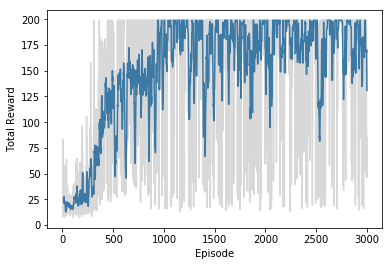

In [134]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')